In [18]:
#import packages we need
import os
import imageio
import numpy as np
from tqdm.notebook import tqdm
import scipy.linalg as la
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation
%matplotlib inline

In [2]:
def dYdt(Y, t):
    pbar.reset()
    pbar.update(t)
    pbar.refresh()
    n = len(Y)
    phi = Y[0:int(n / 2)] #we know n is even since Y = [phi phi_dot]
    phi_dot = Y[int(n / 2):n]
    
    #get rod tip data (pos vel acc)
    xlsx_files = make_xlsx_files()
    xt = get_xt(t)
    yt = get_yt(t)
    xt_dot = get_xt_dot(t)
    yt_dot = get_yt_dot(t)
    xt_ddot = get_xt_ddot(t)
    yt_ddot = get_yt_ddot(t)

    # print(t, xt, yt, xt_dot, yt_dot)
    
    #build little a, then invert and put into M
    #a needs to be n/2 by n/2 np.array/matrix
    A = build_bigA(phi, phi_dot, mass)
    a = build_a(phi, phi_dot, A, length, mass)
    ainv = la.inv(a)

    #build RHS vector Q
    Q = build_Q(phi, phi_dot, mass, length, radius, xt, yt, xt_dot, yt_dot, xt_ddot, yt_ddot, A)
    
    #matrix [I 0;0 ainv]  #see eqn 32 of wang paper
    M = np.zeros((n, n))
    for i in range(n // 2):
        M[i, i] = 1.
    
    for i in range(n // 2):
        for j in range(n // 2):
            M[n // 2 + i, n // 2 + j] = ainv[i, j]

    b = np.zeros((n, 1))
    for i in range(n // 2):
        b[i] = phi_dot[i]
        b[n // 2 + i] = Q[i]

    Y_dot = M@b
    Y_dot = Y_dot.flatten()

    if xlsx_files:
        df_A = pd.DataFrame(data=A[0:,0:])
        df_A.to_excel("big_a.xlsx")

        df_a = pd.DataFrame(data=a[0:,0:])
        df_a.to_excel("little_a.xlsx")

        df_Q = pd.DataFrame(data=Q[0:,0:])
        df_Q.to_excel("Q.xlsx")

        df_ainv = pd.DataFrame(data=ainv[0:,0:])
        df_ainv.to_excel("ainv.xlsx")

        df_M = pd.DataFrame(data=M[0:,0:])
        df_M.to_excel("M.xlsx")
        
        df_b = pd.DataFrame(data=b[0:,0:])
        df_b.to_excel("b.xlsx")

        df_phi = pd.DataFrame(data=phi[0:])
        df_phi.to_excel("phi.xlsx")

        df_phi_dot = pd.DataFrame(data=phi_dot[0:])
        df_phi_dot.to_excel("phi_dot.xlsx")

        df_Y_dot = pd.DataFrame(data=Y_dot[0:])
        df_Y_dot.to_excel("Y_dot.xlsx")
    
    return Y_dot

In [3]:
#helper routines to build RHS vectors and matrices

def build_Q(phi, phi_dot, mass, length, radius, xt, yt, xt_dot, yt_dot, xt_ddot, yt_ddot, A):
    n = len(phi)
    Q = np.zeros((n, 1))
    rhoa = 1.225 * np.pi * np.power(0.0005205,2) * 0.1 # roughly 1.225 kg/m^3
    CS = 0.005

    for i in range(n):
        y_force = get_y_force(phi, i, yt, length)
            
        s = mass[i] * 0.5 * length[i] * (y_force * np.cos(phi[i]) - np.sin(phi[i]) * xt_ddot+np.cos(phi[i]) * yt_ddot)

        for k in range(i, n):
            y_force = get_y_force(phi, k, yt, length)

            if k != i:
                s += mass[k] * length[i] * (y_force * np.cos(phi[i]) - np.sin(phi[i]) * xt_ddot + np.cos(phi[i]) * yt_ddot)
        Q[i] = -s

        s = 0
        for k in range(i, n):
            if k != i:
                s += A[i, k] * length[i] * length[k] * phi_dot[k] ** 2 * np.sin(phi[k] - phi[i])
        Q[i] += s

        # cos(phi[k] - phi[i]) = 1 when i = k therefore cos is not needed
        s = get_CD(get_Re(phi, phi_dot, i, radius, length, xt_dot, yt_dot)) * rhoa * radius[i] *length[i] * get_ViD(xt_dot, yt_dot, phi, i) * \
            np.abs(get_ViD(xt_dot, yt_dot, phi, i)) * 0.5 * length[i]
        
        for k in range(i, n):
            if k != i:              
                s += get_CD(get_Re(phi, phi_dot, k, radius, length, xt_dot, yt_dot)) * rhoa * radius[k] * length[k] * get_ViD(xt_dot, yt_dot, phi, k) * \
                    np.abs(get_ViD(xt_dot, yt_dot, phi, k)) * length[i] * np.cos(phi[k] - phi[i])
        Q[i] += -s

        # sin(phi[i] - phi[k]) = 0 when i = k therefore s = 0
        s = 0
        for k in range(i, n):
            if k != i:
                s += CS * rhoa * np.pi * radius[k] * length[k] * get_ViS(xt_dot, yt_dot, phi, k) * \
                    np.abs(get_ViS(xt_dot, yt_dot, phi, k)) * length[i] * np.sin(phi[i] - phi[k])
        Q[i] += -s
    return Q



def build_a(phi, phi_dot, A, length, mass):
    #build little a matrix from wang paper
    #mass is vector of segment masses
    #L is vector of segment lengths
    #A is big A matrix 
    n = len(phi)
    a = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                s = mass[j] * length[j] * length[j] * 0.25
                for k in range(i,n):
                    s+= mass[k] * length[k] * length[k]
                a[i, j] = s
            else:
                a[i, j] = A[i, j] * length[i] * length[j] * np.cos(phi[i] - phi[j])
    return a

def build_bigA(phi, phi_dot, mass):
    #build big A matrix from wang paper
    #mass is vector of masses of segments
    n = len(phi)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j > i:
                s = 0
                for k in range(j, n):
                    s += mass[k] - 0.5 * mass[j]
                A[i, j] = s
            else:
                s = 0
                for k in range(i, n):
                    s += mass[k] - 0.5 * mass[i]
                A[i, j] = s
    return A

In [4]:
#Reynolds number, drag, and dissipation calculations

def get_Re(phi, phi_dot, i, radius, length, xt_dot, yt_dot):
    #return the Reynolds number for segment i
    #r is the radius of the segment
    #L is a vector of segment lengths
    Re = 0.
    Re = 1.364e5 * radius[i] * np.sqrt(get_x_dot(phi, phi_dot, i, xt_dot, length) ** 2 + get_y_dot(phi, phi_dot, i, yt_dot, length) ** 2)
    return Re

def get_CD(Re):
    #return drag coefficient in normal direction
    #Re is Reynolds number
    CD = 0.
    if Re < 1:
        return 7.16
    if Re < 34:
        return 7.16 * Re ** -0.42
    if Re < 1580:
        return 3.02 * Re ** -0.165
    else:
        return 0.9
    return CD
#note CS = 0.005 constant dont need a function here

def get_y_force(phi, i, yt, length):
    y_force = 9.8 #gravity
    ground_spring_constant = 10
    ground_level = 0.

    y_level = get_y(phi, i, yt, length)

    if y_level <= ground_level:
        y_force = y_level * ground_spring_constant

    # print(round(y_level,3), np.sign(y_force))
    return y_force

In [5]:
#routines to get positions and velocities

def get_x(phi, i, xt, length):
    #get x at position i
    #rod tip x coordinate at xt
    #L is vector of segment Lengths
    s = xt
    for j in range(i):
        s += length[j] * np.cos(phi[j])
    s+= length[i] * np.cos(phi[i]) * 0.5 
    return s

def get_y(phi, i, yt, length):
    #get y at position i
    #rod tip y coordinate at yt
    #L is vector of segment Lengths
    s = yt
    for j in range(i):
        s += length[j] * np.sin(phi[j])
    s+= length[i] * np.sin(phi[i]) * 0.5 
    return s

def get_x_and_y_arrays(phi, length, xt, yt):
    n = len(phi) #L also has length n
    x = np.zeros(n)
    y = np.zeros(n) 
    for i in range(n):
        x[i] = get_x(phi, i, xt, length)
        y[i] = get_y(phi, i, yt, length)
    return x, y

def get_x_dot(phi, phi_dot, i, xt_dot, length):
    #get xdot at position i
    #rod tip x coordinate movign with velocity xt_dot
    #L is vector of segment Lengths
    s = xt_dot
    for j in range(i):
        s += -length[i] * np.sin(phi[j]) * phi_dot[j]
    s+= -length[i] * 0.5 * np.sin(phi[i]) * phi_dot[i] 
    return s

def get_y_dot(phi, phi_dot, i, yt_dot, length):
    #get Y_dot at position i
    #rod tip y coordinate moving with velocity yt_dot
    #L is vector of segment Lengths
    s = yt_dot
    for j in range(i):
        s += length[j] * np.cos(phi[j]) * phi_dot[j]
    s+= length[i]* 0.5 * np.cos(phi[i]) * phi_dot[i] 
    return s

def get_ViD(xt_dot, yt_dot, phi, i):
    # get VD at i
    return -xt_dot * np.sin(phi[i]) + yt_dot * np.cos(phi[i])

def get_ViS(xt_dot, yt_dot, phi, i):
    # get VS at i
    return xt_dot * np.cos(phi[i]) + yt_dot * np.sin(phi[i])

In [6]:
#rod tip and related functions 

### static rod for now - can replace with analytic functions or read from data file later 

def get_xt(t):
    #get rod tip x position at time t
    A = 1
    xt = A * t
    return xt

def get_yt(t):
    #get rod tip y position at time t
    yt = 3  #3 meter high rod for now
    return yt

def get_xt_dot(t):
    #get rod tip x velocity at time t
    A = 1
    xt_dot = A
    return xt_dot

def get_yt_dot(t):
    #get rod tip y velocity at time t
    yt_dot = 0
    return yt_dot

def get_xt_ddot(t):
    #get rod tip x acceleration at time t
    xt_ddot = 0
    return xt_ddot

def get_yt_ddot(t):
    #get rod tip y acceleration at time t
    yt_ddot = 0
    return yt_ddot

def get_time_array():
    return False

def get_max_time():
    max_time = 0.05
    return max_time

def get_total_time_intervals():
    total_time_intervals = 101
    return total_time_intervals

In [7]:
#line functions

def get_number_of_points(df):
    npts = len(df.index)
    return npts

def get_length_array(df):
    #length = 0.1 * np.ones(npts)
    length = df["Length"].to_numpy()
    return length

def get_radius_array(df):
    #radius = 0.001 * np.ones(npts)
    radius = df["Radius"].to_numpy()
    return radius

def get_mass_array(df):
    #mass = 0.01 * np.ones(npts)
    mass = df["Mass"].to_numpy()
    return mass

def get_phi_init_array(df, npts):
    #phi_init = np.zeros((npts, 1))
    phi_init = df["Phi Init"].to_numpy()
    phi_init = np.reshape(phi_init, (npts, 1))
    return phi_init

def get_phi_dot_init_array(df, npts):
    #phi_dot_init = np.zeros((npts, 1))
    phi_dot_init = df["Phi Dot Init"].to_numpy()
    phi_dot_init = np.reshape(phi_dot_init, (npts, 1))
    return phi_dot_init

In [8]:
def make_xlsx_files():
    xlsx_files = False
    return xlsx_files

def get_dataframe(location):
    df = pd.read_csv(location)
    return df

In [9]:
#plot data
def plotdata(x, y, x_max, x_min, y_max, title):
    #change the plot labels and size
    fontsize = 20
    plt.title(title, fontsize=fontsize)
    plt.xlabel("Length", fontsize=fontsize)
    plt.ylabel("Height", fontsize=fontsize)
    plt.rcParams["figure.figsize"] = (20, 15)
    plt.xlim([x_min - 0.5, x_max + 0.5])
    plt.ylim([-0.5, y_max + 0.5])
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.plot(x, y, 'bo-')
    plt.plot([-sum(length) - 0.5, sum(length) + 0.5], [0,0], 'k-')
    return plt

In [16]:
def plot_init_data(phi, length):
    n = len(phi) #L also has length n\n",
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        x[i] = get_x(phi, i, get_xt(0), length)
        y[i] = get_y(phi, i, get_yt(0), length)

    x_max = np.max(x)
    x_min = np.min(x)
    y_max = np.max(y)

    #change the plot labels and size
    fontsize = 20
    plt.title("Initial Condition", fontsize=fontsize)
    plt.xlabel("Length", fontsize=fontsize)
    plt.ylabel("Height", fontsize=fontsize)
    plt.rcParams["figure.figsize"] = (20, 15)
    plt.xlim([x_min - 0.5, x_max + 0.5])
    plt.ylim([-0.5, y_max + 0.5])
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.plot(x, y, 'bo-')
    plt.plot([-sum(length) - 0.5, sum(length) + 0.5], [0,0], 'k-')
    return plt

In [49]:
def makegif(sol, length, npts): #Make rod tip red and the line nodes blue
    # Create the images directory if not already created
    try:
        cwd = os.getcwd()
        os.mkdir(f"{cwd}//images") 
    except:
        pass 

    tti = get_total_time_intervals()
    # TODO Replace with get time array
    time_arr = np.linspace(0, get_max_time(), tti)

    images = []
    location = []
    for i in range(tti):
        location.append(get_x_and_y_arrays(sol[i, 0:npts], length, get_xt(time_arr[i]), get_yt(time_arr[i])))

    for i in range(tti):
        plotdata(location[i][0], location[i][1], np.max(x), np.min(x), np.max(y), f"Time: {round(time_arr[i], 5)} second(s)")
        filepath = f"{cwd}//images//Flyline at {round(time_arr[i], 5)} seconds.png"
        plt.savefig(filepath)
        images.append(imageio.imread(filepath))
        plt.clf()
    imageio.mimsave('Flyline.gif', images, format="GIF", duration=0.1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Tanks\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

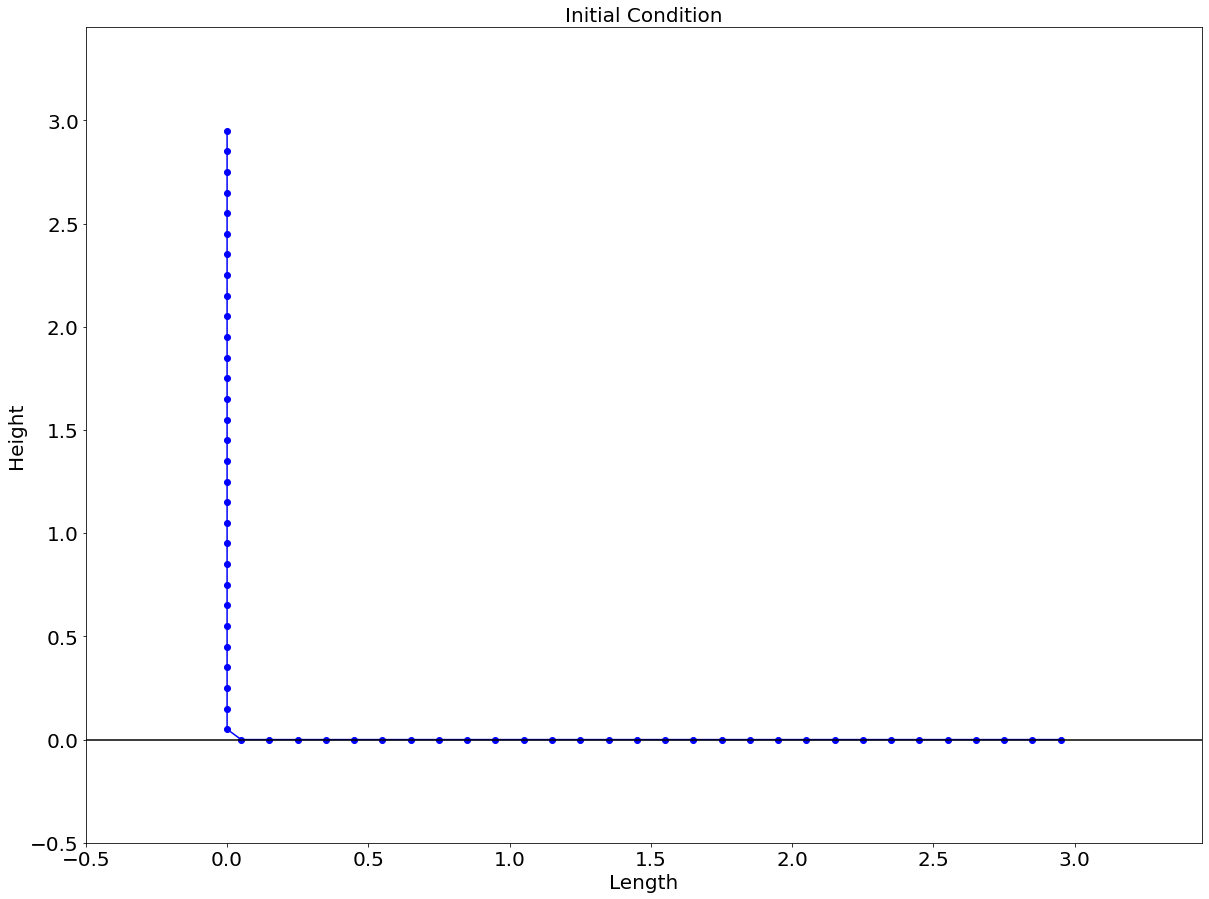

In [17]:
#main driver routine -- 
##--- set up parameter values/initial conditions and call odeint

#parameter values
df_flyline = get_dataframe(r"Flyline.csv")
npts = get_number_of_points(df_flyline) #number of points along fly line
t = np.linspace(0., get_max_time(), get_total_time_intervals()) #simulate one second in time in steps of 0.01

# print(t)

length = get_length_array(df_flyline) 
radius = get_radius_array(df_flyline)
mass = get_mass_array(df_flyline)

#inital conditions
##rod tip
xt = get_xt(0) 
yt = get_yt(0)
##initial angles/velocities
phi_init = get_phi_init_array(df_flyline, npts)
phi_dot_init = get_phi_dot_init_array(df_flyline, npts)
##initial solution vector
Yinit = np.append(phi_init, phi_dot_init)

#plot initial condition
x, y = get_x_and_y_arrays(phi_init, length, xt, yt)
plot_init_data(phi_init, length)

#do stuff with solution - plot, analyze, etc

In [12]:
# create progress bar
pbar = tqdm(total=get_max_time())

#call odeint
sol = odeint(dYdt, Yinit, t) #solve the system of ODEs

  0%|          | 0/0.05 [00:00<?, ?it/s]

In [50]:
makegif(sol, length, npts)

<Figure size 1440x1080 with 0 Axes>

In [36]:
#print(sol[100,:])
#plt.plot(sol)